### Классификация: превышает ли значение CC50 медианное значение выборки

In [1]:
import numpy as np
import pandas as pd

In [2]:
df_scaled = pd.read_csv('df_scaled.csv')

In [3]:
df_scaled.shape

(969, 188)

In [4]:
df_scaled.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


### Сравнены различные модели с настройкой гиперпараметров, сделаны выводы о применимости методов, даны рекомендации по улучшению.

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import optuna

# Загрузка данных
# df_scaled - DataFrame, содержащий данные, в том числе 'CC50'
y = df_scaled['CC50']  # Целевая переменная
median_cc50 = y.median()
y_binary = (y > median_cc50).astype(int)  # Бинарная целевая переменная
X = df_scaled.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.30, random_state=42)

# Словарь классификаторов для оптимизации
CLASSIFIERS = {
    'XGBClassifier': XGBClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'CatBoostClassifier': CatBoostClassifier
}

# Функция для объектов обработки с использованием Optuna
def objective(trial, classifier_name):
    # Определяем параметры для каждого классификатора
    if classifier_name == 'XGBClassifier':
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBClassifier(**params)
    
    elif classifier_name == 'DecisionTreeClassifier':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeClassifier(**params)

    elif classifier_name == 'RandomForestClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == 'CatBoostClassifier':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  # Отключаем вывод информации о процессе обучения
        }
        model = CatBoostClassifier(**params)

    # Обучение модели
    model.fit(X_train, y_train)

    # Прогнозирование на тестовой выборке
    y_pred = model.predict(X_test)

    # Оценка модели
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Возвращаем accuracy для оптимизации

# Оптимизация гиперпараметров для каждого классификатора
best_models = {}
for classifier_name in CLASSIFIERS.keys():
    print(f"Оптимизация гиперпараметров для {classifier_name}...")
    study = optuna.create_study(direction='maximize')  # Максимизируем accuracy
    study.optimize(lambda trial: objective(trial, classifier_name), n_trials=250)  # Число итераций оптимизации

    # Сохранение наилучших параметров и модели
    best_models[classifier_name] = {
        'best_params': study.best_params,
        'best_model': CLASSIFIERS[classifier_name](**study.best_params).fit(X_train, y_train)
    }

    print(f"Оптимальные гиперпараметры для {classifier_name}:", study.best_params)

# Оценка всех моделей на тестовой выборке
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"{classifier_name} - Тестовая точность: {accuracy}, Тестовый F1-score: {f1}")


[I 2025-05-24 11:21:45,751] A new study created in memory with name: no-name-f2d6a37f-2d82-46df-8a6d-23863541b894


Оптимизация гиперпараметров для XGBClassifier...


[I 2025-05-24 11:21:46,521] Trial 0 finished with value: 0.7250859106529209 and parameters: {'learning_rate': 0.00025545802182607954, 'max_depth': 9, 'n_estimators': 228, 'subsample': 0.5410707425954513, 'colsample_bytree': 0.5361053379917311}. Best is trial 0 with value: 0.7250859106529209.
[I 2025-05-24 11:21:47,059] Trial 1 finished with value: 0.7628865979381443 and parameters: {'learning_rate': 0.00042970506653495583, 'max_depth': 4, 'n_estimators': 382, 'subsample': 0.6215247469313209, 'colsample_bytree': 0.9321424110346554}. Best is trial 1 with value: 0.7628865979381443.
[I 2025-05-24 11:21:47,603] Trial 2 finished with value: 0.7663230240549829 and parameters: {'learning_rate': 0.03193761393304439, 'max_depth': 3, 'n_estimators': 506, 'subsample': 0.8674250688832004, 'colsample_bytree': 0.9957168835239865}. Best is trial 2 with value: 0.7663230240549829.
[I 2025-05-24 11:21:47,825] Trial 3 finished with value: 0.7663230240549829 and parameters: {'learning_rate': 0.007017874794

Оптимальные гиперпараметры для XGBClassifier: {'learning_rate': 0.31693647454938384, 'max_depth': 7, 'n_estimators': 309, 'subsample': 0.6168751135761751, 'colsample_bytree': 0.5604509244671562}
Оптимизация гиперпараметров для DecisionTreeClassifier...


[I 2025-05-24 11:23:39,410] Trial 6 finished with value: 0.738831615120275 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 6 with value: 0.738831615120275.
[I 2025-05-24 11:23:39,443] Trial 7 finished with value: 0.738831615120275 and parameters: {'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 6 with value: 0.738831615120275.
[I 2025-05-24 11:23:39,449] Trial 8 finished with value: 0.6254295532646048 and parameters: {'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.738831615120275.
[I 2025-05-24 11:23:39,456] Trial 9 finished with value: 0.7250859106529209 and parameters: {'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.738831615120275.
[I 2025-05-24 11:23:39,496] Trial 10 finished with value: 0.7491408934707904 and parameters: {'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 10 with val

Оптимальные гиперпараметры для DecisionTreeClassifier: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 8}
Оптимизация гиперпараметров для RandomForestClassifier...


[I 2025-05-24 11:23:48,320] Trial 0 finished with value: 0.7903780068728522 and parameters: {'n_estimators': 405, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.7903780068728522.
[I 2025-05-24 11:23:48,891] Trial 1 finished with value: 0.7800687285223368 and parameters: {'n_estimators': 300, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7903780068728522.
[I 2025-05-24 11:23:49,693] Trial 2 finished with value: 0.7800687285223368 and parameters: {'n_estimators': 404, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7903780068728522.
[I 2025-05-24 11:23:49,974] Trial 3 finished with value: 0.7731958762886598 and parameters: {'n_estimators': 142, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7903780068728522.
[I 2025-05-24 11:23:50,052] Trial 4 finished with value: 0.7800687285223368 and parameters:

Оптимальные гиперпараметры для RandomForestClassifier: {'n_estimators': 413, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1}
Оптимизация гиперпараметров для CatBoostClassifier...


[I 2025-05-24 11:27:10,282] Trial 0 finished with value: 0.7457044673539519 and parameters: {'learning_rate': 0.0001082246287605907, 'depth': 5, 'iterations': 344, 'l2_leaf_reg': 0.0030278997654929474}. Best is trial 0 with value: 0.7457044673539519.
[I 2025-05-24 11:27:10,558] Trial 1 finished with value: 0.738831615120275 and parameters: {'learning_rate': 0.0332751017668262, 'depth': 1, 'iterations': 263, 'l2_leaf_reg': 0.03444647205442079}. Best is trial 0 with value: 0.7457044673539519.
[I 2025-05-24 11:27:32,011] Trial 2 finished with value: 0.7766323024054983 and parameters: {'learning_rate': 0.1761165148736355, 'depth': 9, 'iterations': 549, 'l2_leaf_reg': 8.789336180724737}. Best is trial 2 with value: 0.7766323024054983.
[I 2025-05-24 11:27:41,687] Trial 3 finished with value: 0.7835051546391752 and parameters: {'learning_rate': 0.07244380196325098, 'depth': 9, 'iterations': 247, 'l2_leaf_reg': 0.7864798464728336}. Best is trial 3 with value: 0.7835051546391752.
[I 2025-05-24 

0:	learn: 0.6856119	total: 65.7ms	remaining: 19s
1:	learn: 0.6778867	total: 105ms	remaining: 15.2s
2:	learn: 0.6719583	total: 146ms	remaining: 14s
3:	learn: 0.6639293	total: 188ms	remaining: 13.5s
4:	learn: 0.6549929	total: 233ms	remaining: 13.3s
5:	learn: 0.6450534	total: 281ms	remaining: 13.3s
6:	learn: 0.6376537	total: 327ms	remaining: 13.3s
7:	learn: 0.6306307	total: 372ms	remaining: 13.2s
8:	learn: 0.6246976	total: 422ms	remaining: 13.2s
9:	learn: 0.6180347	total: 472ms	remaining: 13.3s
10:	learn: 0.6144972	total: 514ms	remaining: 13.1s
11:	learn: 0.6074941	total: 558ms	remaining: 13s
12:	learn: 0.6020775	total: 605ms	remaining: 12.9s
13:	learn: 0.5951886	total: 646ms	remaining: 12.8s
14:	learn: 0.5901615	total: 690ms	remaining: 12.7s
15:	learn: 0.5833965	total: 734ms	remaining: 12.6s
16:	learn: 0.5788649	total: 776ms	remaining: 12.5s
17:	learn: 0.5732115	total: 820ms	remaining: 12.4s
18:	learn: 0.5673692	total: 871ms	remaining: 12.5s
19:	learn: 0.5643612	total: 921ms	remaining: 1

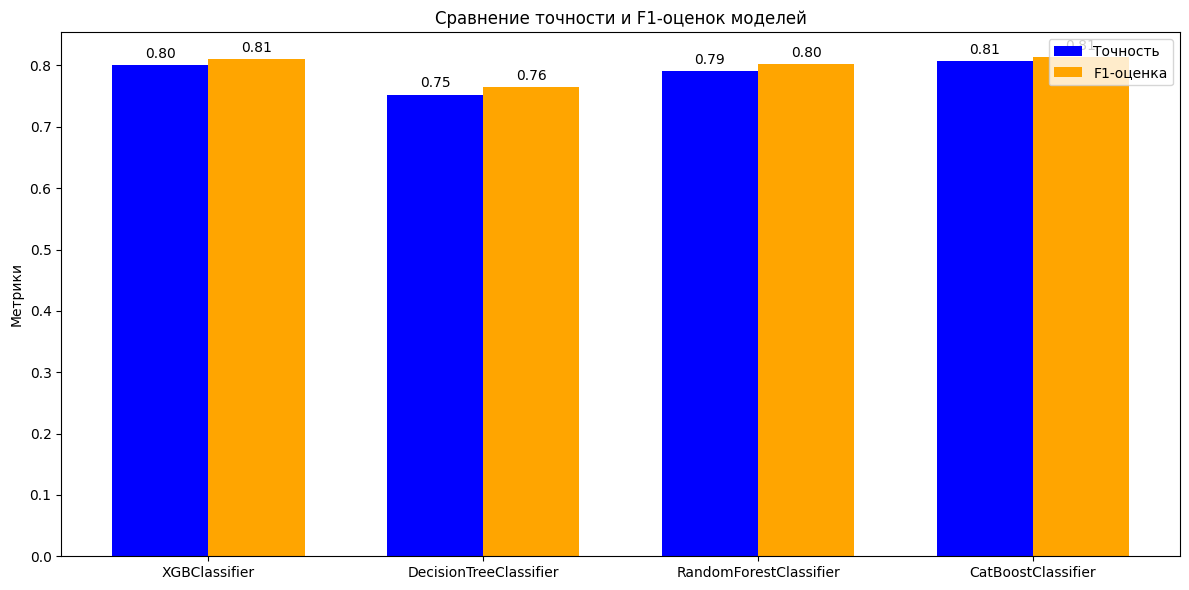

In [6]:
# Визуализация результатов
import matplotlib.pyplot as plt

# Сбор данных для визуализации
models_names = list(best_models.keys())
accuracies = []
f1_scores = []

# Заполнение массивов оценками каждой модели
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    accuracies.append(accuracy)
    f1_scores.append(f1)

# Визуализация результатов
x = np.arange(len(models_names))  # метки для оси x
width = 0.35  # ширина столбцов

fig, ax = plt.subplots(figsize=(12, 6))

# Построение столбчатых диаграмм для точности и F1-оценок
bars1 = ax.bar(x - width/2, accuracies, width, label='Точность', color='blue')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-оценка', color='orange')

# Настройка отметок оси x и заголовка
ax.set_ylabel('Метрики')
ax.set_title('Сравнение точности и F1-оценок моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()

# Добавление значений над столбцами
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # Отодвигаем значение немного вверх
                    textcoords="offset points", 
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

# Отображение графика
plt.tight_layout()
plt.show()

*На основе предоставленных результатов тестирования для различных классификаторов, можно сделать следующие выводы:*

- *1. Сравнение моделей*
- *XGBClassifier:*
- Точность: 0.8007
- F1-score: 0.8105
- *DecisionTreeClassifier:*
- Точность: 0.7526
- F1-score: 0.7647
- *RandomForestClassifier:*
- Точность: 0.7904
- F1-score: 0.8026
- *CatBoostClassifier:*
- Точность: 0.8076
- F1-score: 0.8133
- *2. Анализ моделей*
- Лучшие показатели:
- CatBoostClassifier достигает наилучших результатов по обоим метрикам: точности (0.8076) и F1-score (0.8133). Это говорит о его высокой способности к обобщению и балансировке между точностью и полнотой.
- Наименьшие показатели:
- DecisionTreeClassifier показывает наименьшие результаты по обеим метрикам. Это может указывать на переобучение или недостаточную сложность модели для решения данной задачи.
- *3. Выводы*
- CatBoostClassifier и XGBClassifier являются наиболее эффективными моделями для этой задачи, с CatBoost, который слегка опережает XGBoost по обоим метрикам.
- RandomForestClassifier также демонстрирует приемлемые результаты, но не достигает уровня CatBoost и XGBoost.
- Результаты DecisionTreeClassifier указывают на необходимость его оптимизации или рассмотрения более сложных моделей для улучшения производительности.
- *4. Рекомендации*
- Рассмотреть возможность использования CatBoostClassifier для дальнейшего применения, поскольку он продемонстрировал наивысшую производительность.
- Можно провести дополнительный анализ и оптимизацию гиперпараметров для всех моделей, чтобы улучшить их производительность.
- Рассмотреть использование методов ансамблевого обучения для дальнейшего повышения точности.

*Данный код демонстрирует процесс сохранения и загрузки обученных моделей машинного обучения с использованием библиотеки `pickle` в Python.*

In [7]:
import pickle
from sklearn.metrics import mean_squared_error, r2_score

# Функция для сохранения модели
def save_model(model, model_name):
    filename = f"{model_name}_CC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
        print(f"Модель '{filename}' сохранена.")

# Функция для загрузки модели
def load_model(model_name):
    filename = f"{model_name}_CC50.pkl"
    try:
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Модель '{filename}' загружена.")
        return model
    except FileNotFoundError:
        print(f"Ошибка: файл '{filename}' не найден.")
        return None

# Сохранение обученных моделей
for classifier_name, model_data in best_models.items():
    save_model(model_data['best_model'], classifier_name)

# Загрузка моделей для использования
loaded_models = {
    'XGBClassifier': load_model('XGBClassifier'),
    'DecisionTreeClassifier': load_model('DecisionTreeClassifier'),
    'RandomForestClassifier': load_model('RandomForestClassifier'),
    'CatBoostClassifier': load_model('CatBoostClassifier')
}


Модель 'XGBClassifier_CC50.pkl' сохранена.
Модель 'DecisionTreeClassifier_CC50.pkl' сохранена.
Модель 'RandomForestClassifier_CC50.pkl' сохранена.
Модель 'CatBoostClassifier_CC50.pkl' сохранена.
Модель 'XGBClassifier_CC50.pkl' загружена.
Модель 'DecisionTreeClassifier_CC50.pkl' загружена.
Модель 'RandomForestClassifier_CC50.pkl' загружена.
Модель 'CatBoostClassifier_CC50.pkl' загружена.
